In [150]:
from neo4j import __version__ as neo4j_version
from neo4j import GraphDatabase
import pandas as pd
import networkx as nx
import import_ipynb
from louvain_ascendency import*
from mixer_ascendency import*
from Neo4j import *
import matplotlib.pyplot as plt

In [151]:
conn = Neo4jConnection(uri="bolt://localhost:7687", 
                       user="neo4j",              
                       pwd="uniswap")

In [152]:
class graph_analyser():
    
    def __init__(self, conn):
        self.conn = conn
        self.addresses_in_large_communities = {} # communitity id => addresses in community
        self.large_communities = [] # stores ids of large communities
        self.subgraphs = {} # adjacency matrices of subgraphs of all communities 
        self.metrics_by_community = {} # dict of dicts of graph state metrics by community
        self.metric_names = ["Average Mutual Information", "Development capacity", "Ascendency", "Redundancy"]
        self.address_to_node_by_subgraph = {} # dicts of address to node in each subgraph
        
    def find_large_communities(self, threshold):
        query_string = '''MATCH (n:Address)
                        WHERE EXISTS(n.communityId)
                        RETURN n.communityId AS communityId, COUNT(*) AS size
                        ORDER BY size DESC'''

        size_of_communities = pd.DataFrame([dict(_) for _ in self.conn.query(query_string)])
        
        for index, row in size_of_communities.iterrows():
            if(row['size'] > threshold):
                self.large_communities.append(row['communityId'])
        return self.large_communities
    
    def get_all_community_addresses(self, community_id):
        query_string = '''MATCH (n)
                          WHERE n.communityId = ''' 
        query_string = query_string + str(community_id) 
        query_string += '''RETURN n.id as id'''

        addresses_in_community = pd.DataFrame([dict(_) for _ in self.conn.query(query_string)])
        return addresses_in_community['id'].tolist()
    
    def get_all_addresses_from_large_communities(self):
        
        
        for community in self.large_communities:
            self.addresses_in_large_communities[community] = self.get_all_community_addresses(community)
        
    def get_node_degree(self, node_address):
    
        query_string = '''MATCH (n:Address {id: \"'''
        query_string += str(node_address)
        query_string +=  '"})'
        query_string += '''RETURN apoc.node.degree(n) AS degree '''

        degree = pd.DataFrame([dict(_) for _ in self.conn.query(query_string)])

        return degree['degree'][0]
    
    def get_address_with_highest_degree(self, community_id):
        a = "0x"
        highest_degree = 0
        for address in self.large_communities[community_id]:
            node_degree = self.get_node_degree(address, self.conn)
            if node_degree > highest_degree:
                highest_degree = node_degree
                a = address

        return a, highest_degree
    
    def get_subgraph_by_community_id(self, community_id):
        
        query_string = '''MATCH (a1:Address)-[r:TRANSFERED_UNI]->(a2:Address)'''
        query_string += '''WHERE a1.communityId = ''' + str(community_id) 
        query_string +=  '''AND a2.communityId =''' + str(community_id)
        query_string += '''RETURN a1.id as From, a2.id as To, r.value as value'''

        subgraph = pd.DataFrame([dict(_) for _ in self.conn.query(query_string)])
        
        return subgraph
    
    def convert_subgraph_into_adj_matrix(self, subgraph):
        
        Graphtype = nx.DiGraph()
        G=nx.from_pandas_edgelist(subgraph, 'From', 'To', ['value'], create_using=Graphtype)
        g_numpy = nx.to_numpy_array(G)
        
        return g_numpy 
    
    def calculate_metrics(self, subgraph_adj_matrix):
       
        ami = measure_average_mutual_information(subgraph_adj_matrix)
        dc = measure_development_capacity(subgraph_adj_matrix)
        a = measure_ascendency(subgraph_adj_matrix)
        r = measure_redundancy(subgraph_adj_matrix)
        
        return ami, dc, a, r
    
    def find_all_subgraphs(self):
        
        for community_id in self.large_communities:
            graph_df = self.get_subgraph_by_community_id(community_id)
            self.subgraphs[community_id] = self.pandas_edge_list_to_adj_matrix(graph_df, community_id)
        
        
    def calculate_metrics_for_all_subgraphs(self):
        
        for community_id in self.subgraphs:
            self.metrics_by_community[community_id] ={}
            metrics = self.calculate_metrics(self.subgraphs[community_id])
            for count, metric in enumerate(metrics):
                self.metrics_by_community[community_id][self.metric_names[count]] = metric
    
    def pandas_edge_list_to_adj_matrix(self, graph_df, community_id):
        """
        From = graph_df['number_to']
        To = graph_df['number_from']
        all_addresses = From + To
        number_of_unique_addresses = np.unique(np.array(all_addresses))
        adj_matrix  = np.array((number_of_unique_addresses, number_of_unique_addresses))
        for index, row in graph_df.iterrows():
            adj_matrix[row[]]
        """
        
        #graph_df = pd.crosstab(graph_df.From, graph_df.To)
        
        address_to_node ={}
        count = 0
        for index, row in graph_df.iterrows():
            address = row["From"]
            if address not in address_to_node:
                address_to_node[address] = count 
                count += 1
            address = row["To"]
            if address not in address_to_node:
                address_to_node[address] = count 
                count += 1
        size = len(address_to_node.keys())
        
        adj_matrix = np.zeros((size, size))
        self.address_to_node_by_subgraph[community_id] = address_to_node
        
        for index, row in graph_df.iterrows():
            adj_matrix[address_to_node[row["From"]]][address_to_node[row["To"]]] = row["value"]
        
       
        return adj_matrix
    

    

In [153]:
analyser = graph_analyser(conn)

In [154]:
threshold = 20
analyser.find_large_communities(threshold)
analyser.get_all_addresses_from_large_communities()
analyser.find_all_subgraphs()
analyser.calculate_metrics_for_all_subgraphs()
print(analyser.metrics_by_community)

{13: {'Average Mutual Information': 0.7599828037430371, 'Development capacity': -25.03512324802875, 'Ascendency': 16.16439618152631, 'Redundancy': -0.417064760819492}, 46: {'Average Mutual Information': 0.15336043562882273, 'Development capacity': -1253.9941414577331, 'Ascendency': 471.0667613254448, 'Redundancy': -0.25488973950311883}, 1040: {'Average Mutual Information': 0.5195577792696067, 'Development capacity': -2.0597779513278707, 'Ascendency': 2.028069995632619, 'Redundancy': -0.008123050526698233}, 5: {'Average Mutual Information': 0.43075703295897366, 'Development capacity': -0.29639073627466034, 'Ascendency': 0.2584226883605716, 'Redundancy': -0.06328780096853279}, 33: {'Average Mutual Information': 0.9350389567461875, 'Development capacity': -33.881784190265286, 'Ascendency': 32.422159501494974, 'Redundancy': -0.042094850164618156}, 29: {'Average Mutual Information': 0.36766276796161673, 'Development capacity': -25.185637987928214, 'Ascendency': 15.834710430440458, 'Redundan

In [160]:
metrics_by_community = analyser.metrics_by_community
metric_names = analyser.metric_names

ami = np.array([])
dc = np.array([])
a = np.array([])
r = np.array([])
community_sizes = np.array([])
number_of_edges = np.array([])

for key in metrics_by_community:
    community_sizes = np.append(community_sizes, len(analyser.addresses_in_large_communities[key]))
    number_of_edges = np.append(number_of_edges, np.count_nonzero(analyser.subgraphs[key]))
    ami = np.append(ami, metrics_by_community[key][metric_names[0]])
    dc = np.append(dc, metrics_by_community[key][metric_names[1]])
    a = np.append(a, metrics_by_community[key][metric_names[2]])
    r = np.append(r, metrics_by_community[key][metric_names[3]])

all_metrics = [ami, dc, a, r]

for count, metric in enumerate(all_metrics):
    print("Mean of ", metric_names[count], " is ", np.average(metric))
    print("Standard Deviation of ", metric_names[count], " is ", np.std(metric))
    print("Max of ", metric_names[count], " is ", np.max(metric))
    print("Min of ", metric_names[count], " is ", np.min(metric))
    print(" ")
print(number_of_edges)

Mean of  Average Mutual Information  is  0.3001274395543199
Standard Deviation of  Average Mutual Information  is  0.28687844665458756
Max of  Average Mutual Information  is  0.9350389567461875
Min of  Average Mutual Information  is  -7.295016122338968e-17
 
Mean of  Development capacity  is  -57.5548435339393
Standard Deviation of  Development capacity  is  240.7095845668312
Max of  Development capacity  is  0.0
Min of  Development capacity  is  -1253.9941414577331
 
Mean of  Ascendency  is  21.154980113173526
Standard Deviation of  Ascendency  is  90.27251427273181
Max of  Ascendency  is  471.0667613254448
Min of  Ascendency  is  -1.599578185145265e-19
 
Mean of  Redundancy  is  -0.3776246522764227
Standard Deviation of  Redundancy  is  0.3900474101332504
Max of  Redundancy  is  0.0
Min of  Redundancy  is  -1.2573740070833195
 
[982. 636. 203.  11. 139. 198. 179.  75.  11.  21.  92.  68.  12.   5.
  14.   4.   3.  46.  44.  43.   0.  27.  25.  23.  21.  20.]


Average Mutual Information


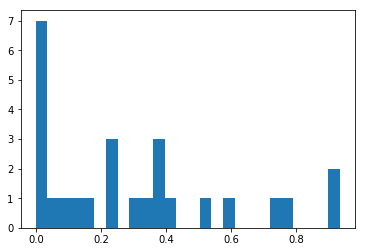

Development capacity


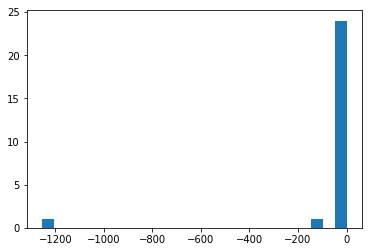

Ascendency


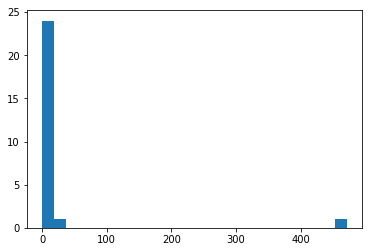

Redundancy


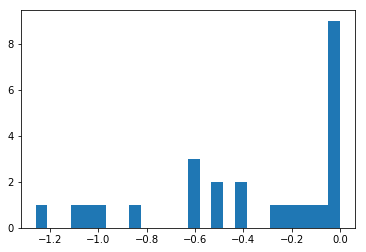

In [161]:
for count, metric in enumerate(all_metrics):
    print(metric_names[count])
    plt.hist(all_metrics[count], bins=len(all_metrics[count]))
    plt.show()

Average Mutual Information


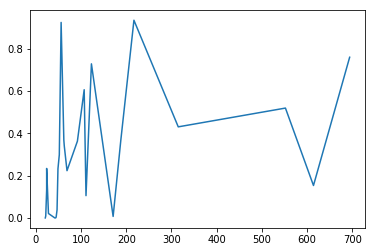

Development capacity


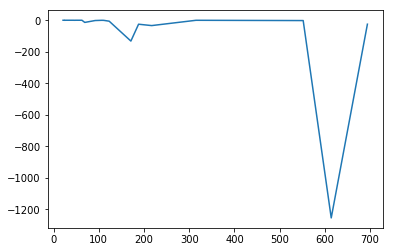

Ascendency


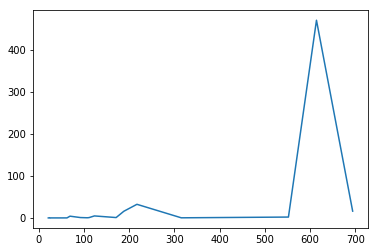

Redundancy


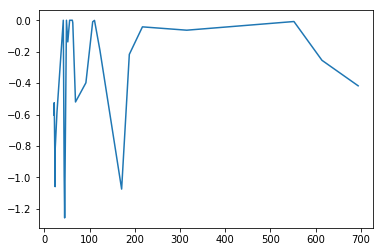

In [165]:

sorted_indicies = np.argsort(community_sizes)
community_sizes = community_sizes[sorted_indicies]

for count, metric in enumerate(all_metrics):
    print(metric_names[count])
    sorted_metric = all_metrics[count][sorted_indicies]
    plt.plot(community_sizes, sorted_metric)
    plt.show()

Average Mutual Information


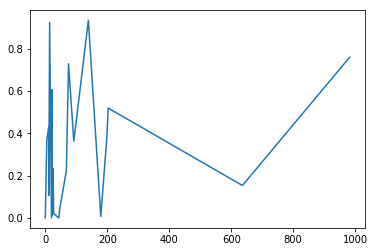

Development capacity


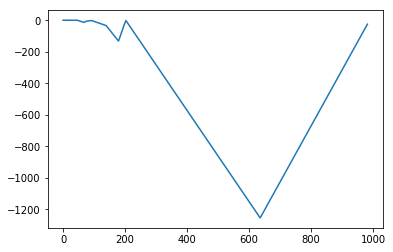

Ascendency


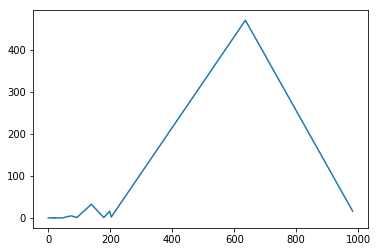

Redundancy


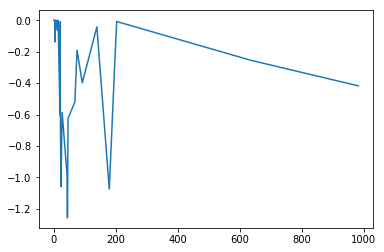

In [166]:
sorted_indicies = np.argsort(number_of_edges)
number_of_edges = number_of_edges[sorted_indicies]

for count, metric in enumerate(all_metrics):
    print(metric_names[count])
    sorted_metric = all_metrics[count][sorted_indicies]
    plt.plot(number_of_edges, sorted_metric)
    plt.show()